In [15]:
import ast
from sklearn.preprocessing import LabelEncoder
import tqdm
import networkx as nx
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report


In [5]:
# Load the datasets
train_df = pd.read_csv('../../data/raw/train.csv')
test_df = pd.read_csv('../../data/raw/test.csv')

# Combine unique populations from both datasets
unique_populations = pd.concat([train_df['Population'], test_df['Population']]).unique()

# Initialize LabelEncoder and fit on combined unique populations
label_encoder = LabelEncoder()
label_encoder.fit(unique_populations)

# Function to preprocess data
def preprocess_data(df):
    # Convert the 'Connections' column from string to list
    df['Connections'] = df['Connections'].apply(ast.literal_eval)

    # Encode the 'Population' column
    df['Population_Encoded'] = label_encoder.transform(df['Population'])

    return df

# Preprocess both datasets
train_df = preprocess_data(train_df)
test_df = preprocess_data(test_df)

In [35]:
def add_graph_features(train_df, test_df, G):
    # Combine the train and test data to build the graph
    combined_df = pd.concat([train_df, test_df], ignore_index=True)

    # Create a dictionary mapping IDs to rows for fast lookup
    id_to_row = {row['ID']: row for _, row in combined_df.iterrows()}

    # Check if 'Infected' column exists in the training data
    has_infected = 'Infected' in train_df.columns

    # Add nodes with attributes
    for index, row in tqdm.tqdm(combined_df.iterrows(), total=combined_df.shape[0]):
        node_attributes = {
            'age': row['Age'],
            'constitution': row['Constitution'],
            'behaviour': row['Behaviour'],
            'population': row['Population']
        }
        if has_infected and 'Infected' in row:
            node_attributes['infected'] = row['Infected']
        G.add_node(row['ID'], **node_attributes)

    # Add edges, ensuring connections are within the same population
    for index, row in tqdm.tqdm(combined_df.iterrows(), total=combined_df.shape[0]):
        for connection in row['Connections']:
            if connection in id_to_row:
                connection_row = id_to_row[connection]
                if row['Population'] == connection_row['Population']:
                    G.add_edge(row['ID'], connection)

    print("Extracting graph features...")
    # Extract graph features
    degree_centrality = nx.degree_centrality(G)
    clustering_coefficient = nx.clustering(G)

    print("Calculating shortest paths...")
    # Calculate shortest paths to index patient for the training data
    if has_infected:
        index_patients = train_df[train_df['Index_Patient'] == 1]['ID'].tolist()
    else:
        index_patients = []

    shortest_paths = {node: float('inf') for node in G.nodes}

    if index_patients:
        # Calculate shortest paths from all index patients to all nodes
        shortest_paths_all = nx.multi_source_dijkstra_path_length(G, index_patients)
        
        # Update the shortest_paths dictionary with the computed shortest paths
        for node, length in shortest_paths_all.items():
            shortest_paths[node] = length

    print("Updating DataFrame with graph features...")
    # Add features to DataFrames
    combined_df['Degree_Centrality'] = combined_df['ID'].map(degree_centrality)
    combined_df['Clustering_Coefficient'] = combined_df['ID'].map(clustering_coefficient)
    combined_df['Number_of_Connections'] = combined_df['Connections'].apply(len)
    combined_df['Distance_to_Index_Patient'] = combined_df['ID'].map(shortest_paths)

    # Separate the combined DataFrame back into train and test DataFrames
    train_df = combined_df[combined_df['ID'].isin(train_df['ID'])]
    test_df = combined_df[combined_df['ID'].isin(test_df['ID'])]

    return train_df, test_df

In [36]:
G_train = nx.Graph()
train_df, test_df = add_graph_features(train_df, test_df, G_train)

100%|██████████| 1300000/1300000 [01:08<00:00, 19030.45it/s]


Extracting graph features...
Calculating shortest paths...
Updating DataFrame with graph features...


In [42]:
# Combine original features with graph features
features = [
    'Age', 'Constitution', 'Behaviour',  'Number_of_Connections', 'Distance_to_Index_Patient'
]

# Split the training data into train and validation sets
X = train_df[features]
y = train_df['Infected']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [43]:
# Initialize and train the model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [44]:
# Evaluate the model on the validation set
y_pred = model.predict(X_val)

In [45]:
# Print evaluation metrics
print("Accuracy:", accuracy_score(y_val, y_pred))
print("Precision:", precision_score(y_val, y_pred))
print("Recall:", recall_score(y_val, y_pred))
print("F1 Score:", f1_score(y_val, y_pred))
print("Classification Report:\n", classification_report(y_val, y_pred))

Accuracy: 0.584023076923077
Precision: 0.5710249375537447
Recall: 0.4571007129394411
F1 Score: 0.5077509853718926
Classification Report:
               precision    recall  f1-score   support

         0.0       0.59      0.70      0.64     68985
         1.0       0.57      0.46      0.51     61015

    accuracy                           0.58    130000
   macro avg       0.58      0.58      0.57    130000
weighted avg       0.58      0.58      0.58    130000



In [46]:
# Get ROC AUC score
from sklearn.metrics import roc_auc_score
roc_auc = roc_auc_score(y_val, model.predict_proba(X_val)[:, 1])
print("ROC AUC Score:", roc_auc)

ROC AUC Score: 0.6114375344664551


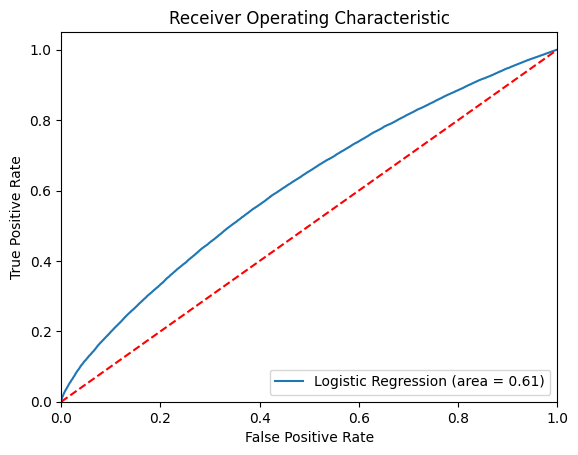

In [47]:
# Plot ROC curve
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_val, model.predict_proba(X_val)[:, 1])

plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()